In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.cuda.manual_seed_all(3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pairs = [('NEM','GOOGL'), ('NEM','TSLA'), ('NEM','GOOG'), ('RCL','GOOGL'), ('RCL','TSLA'), ('RCL','GOOG'), ('MSI','GOOGL'), ('MSI','TSLA'), ('MSI','GOOG')] # closing

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24324/693236447.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  6 of 6 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24324/693236447.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']
[*********************100%***********************]  6 of 6 completed


In [2]:
# def predict_mean_reversion_label(spread, window, threshold):
#     labels = []
#     mean = spread.mean()

#     for i in range(len(spread)):
#         future_spread = spread[i + 1 : i + 1 + window]
#         if len(future_spread) < window:
#             labels.append(np.nan)
#         elif any(abs(j - mean) < threshold for j in future_spread):
#             labels.append(1)
#         else:
#             labels.append(0)

#     return pd.Series(labels, index = spread.index)

def predict_mean_reversion_label(spread, lower, upper):
    mean = spread.mean()
    std = spread.std()
    z_scores = (spread - mean) / std

    labels = ((z_scores <= lower) | (z_scores >= upper)).astype(int)

    return pd.Series(labels, index=spread.index)

In [3]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def create_features(spread, pair, window):
    df = pd.DataFrame({'spread': spread})

    df['z-score'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()
    df['z-score_lag1'] = df['z-score'].shift(1)
    df['spread_lag1'] = df['spread'].shift(1)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    df['z-score_lag2'] = df['z-score'].shift(2)
    df['z-score_lag5'] = df['z-score'].shift(5)

    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

# optimal_window_threshold = {'SPYG_IVW': {'window': 10, 'threshold': 0.03},
#                             'VOO_IVV': {'window': 10, 'threshold': 0.03},
#                             'IVE_SPYV': {'window': 10, 'threshold': 0.03},
#                             'IWB_SPLG': {'window': 10, 'threshold': 0.03},
#                             'IWM_SPSM': {'window': 10, 'threshold': 0.03},
#                             'VTWO_SPSM': {'window': 10, 'threshold': 0.03},
#                             'VO_IWB': {'window': 10, 'threshold': 0.03},
#                             'SPY_IVV': {'window': 10, 'threshold': 0.03}
# }

for etf1, etf2 in pairs:

    pair_name = f'{etf1}_{etf2}'

    window = 5

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, pair_name, window = window)
    test_features = create_features(testing_spread, pair_name, window = window)

    train_labels = predict_mean_reversion_label(training_spread, lower = -1, upper = 1)

    train_features['label'] = train_labels.loc[train_features.index]
    train_features = train_features.dropna(subset=['label'])

    test_labels = predict_mean_reversion_label(testing_spread, lower = -1, upper = 1)
    test_features['label'] = test_labels.loc[test_features.index]
    test_features = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name] = test_features.drop(columns=['label'])
    y_test_dict[pair_name] = test_features['label']


training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [4]:
def create_sequences(X, y, window_size):
    X_seq, y_seq  = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X.iloc[i : i + window_size].values)
        y_seq.append(y.iloc[i + window_size])

    return np.array(X_seq), np.array(y_seq)

In [5]:
class ClassificationLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, input_size, dropout = 0.0):
        super(ClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        dropout = dropout if num_layers > 1 else 0.0
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        # out = self.sigmoid(out)
        return out.squeeze()

In [6]:
def train_model(model, train_loader, criterion, optimizer, epochs = 50, device = 'cpu'):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

In [7]:
def evaluate_model(model, pair_name, test_loader, device = 'cpu'):
    model.eval()
    all_preds = []
    all_true = []
    
    # optimal_thresholds = {'IEMG_EEM': 0.90,
    #                       'ARKK_ARKW': 0.50,
    #                       'TLT_SPTL': 0.50,
    #                       'SHY_VGSH': 0.80,
    #                       'SOXX_ITA': 0.30
    #                       }
    
    # threshold = optimal_thresholds[pair_name]

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    y_pred_label = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    print("Test Accuracy:", accuracy)
    return y_true, y_pred, y_pred_label

In [8]:
def plot_labels(X_df, y_pred_label, pair_name):
    spread = X_df['spread']
    
    aligned_spread = spread[-len(y_pred_label):]
    predicted_points = aligned_spread[y_pred_label == 1]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x=aligned_spread.index, y=aligned_spread.values, label='Spread', color='black')
    sns.scatterplot(x=predicted_points.index, y=predicted_points.values, color='green', label='Predicted Reversion', s=100, marker='o')
    plt.title(f"Predicted Mean Reversions of {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
def print_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label, labels = [0, 1])
    print("Confusion Matrix:")
    print(cm)

In [10]:
def print_f1(y_true, y_pred_label):
    f1 = f1_score(y_true, y_pred_label)
    print(f"F1 Score: {f1:.4f}")

In [11]:
def run_pair(pair_name, X_train_dict, y_train_dict, X_test_dict, y_test_dict, epochs, device='cpu'):
    
    # params = {'IEMG_EEM': {'hidden_size': 30, 'lr': 0.001, 'num_layers': 1, 'window_size': 3, 'batch_size': 32, 'dropout': 0.0},
    #           'ARKK_ARKW': {'hidden_size': 70, 'lr': 0.0001, 'num_layers': 2, 'window_size': 5, 'batch_size': 128, 'dropout': 0.0},
    #           'TLT_SPTL': {'hidden_size': 70, 'lr': 0.0005, 'num_layers': 2, 'window_size': 5, 'batch_size': 32, 'dropout': 0.0},
    #           'SHY_VGSH': {'hidden_size': 30, 'lr': 0.001, 'num_layers': 2, 'window_size': 5, 'batch_size': 32, 'dropout': 0.2},
    #           'SOXX_ITA': {'hidden_size': 70, 'lr': 0.0005, 'num_layers': 1, 'window_size': 5, 'batch_size': 32, 'dropout': 0.0}
    #           }
    
    # hidden_size = params[pair_name]['hidden_size']
    # lr = params[pair_name]['lr']
    # num_layers = params[pair_name]['num_layers']
    # window_size = params[pair_name]['window_size']
    # batch_size = params[pair_name]['batch_size']
    # dropout = params[pair_name]['dropout']

    hidden_size = 70
    lr = 0.001
    num_layers = 2
    window_size = 5
    batch_size = 32
    dropout = 0.0

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype=torch.float32)
    y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)
    
    X_test = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(-1)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    
    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    print(f"\nTraining model for pair: {pair_name}")
    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)
    
    print(f"\nEvaluating model for pair: {pair_name}")
    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    plot_labels(X_test_df, y_pred_label, pair_name)

    print_confusion_matrix(y_true, y_pred_label)

    print_f1(y_true, y_pred_label)
    
    return model, y_true, y_pred

In [12]:
# grid search

def grid_search(pair_name, params, device = 'cpu'):
    window_size = params['window_size']
    epochs = params['epochs']
    hidden_size = params['hidden_size']
    lr = params['learning_rate']
    num_layers = params['num_layers']
    batch_size = params['batch_size']
    dropout = params['dropout']

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype=torch.float32)
    y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)

    X_test = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(-1)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)

    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    f1 = f1_score(y_true, y_pred_label)

    return f1, model, params

In [13]:
def grid_search_for_pair(pair_name, param_grid, device='cpu'):
    keys, values = zip(*param_grid.items())
    best_f1 = -np.inf
    best_params = None
    best_model = None

    for v in product(*values):
        params = dict(zip(keys, v))
        print(f"Testing params: {params}")
        f1, model, _ = grid_search(pair_name, params, device=device)
        print(f"F1 Score: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_params = params
            best_model = model

    print(f"Best params for {pair_name}: {best_params}")
    print(f"Best F1 score: {best_f1:.4f}")
    return best_model, best_params, best_f1


Training model for pair: NEM_GOOGL
Epoch 1/50 - Loss: 0.9351
Epoch 2/50 - Loss: 0.8463
Epoch 3/50 - Loss: 0.7477
Epoch 4/50 - Loss: 0.6235
Epoch 5/50 - Loss: 0.5758
Epoch 6/50 - Loss: 0.4765
Epoch 7/50 - Loss: 0.4495
Epoch 8/50 - Loss: 0.4803
Epoch 9/50 - Loss: 0.4444
Epoch 10/50 - Loss: 0.4242
Epoch 11/50 - Loss: 0.4226
Epoch 12/50 - Loss: 0.4218
Epoch 13/50 - Loss: 0.4199
Epoch 14/50 - Loss: 0.4161
Epoch 15/50 - Loss: 0.4110
Epoch 16/50 - Loss: 0.4060
Epoch 17/50 - Loss: 0.4013
Epoch 18/50 - Loss: 0.3960
Epoch 19/50 - Loss: 0.3891
Epoch 20/50 - Loss: 0.3808
Epoch 21/50 - Loss: 0.3726
Epoch 22/50 - Loss: 0.3650
Epoch 23/50 - Loss: 0.3582
Epoch 24/50 - Loss: 0.3517
Epoch 25/50 - Loss: 0.3461
Epoch 26/50 - Loss: 0.3392
Epoch 27/50 - Loss: 0.3366
Epoch 28/50 - Loss: 0.3314
Epoch 29/50 - Loss: 0.3377
Epoch 30/50 - Loss: 0.3244
Epoch 31/50 - Loss: 0.3030
Epoch 32/50 - Loss: 0.3010
Epoch 33/50 - Loss: 0.2986
Epoch 34/50 - Loss: 0.2981
Epoch 35/50 - Loss: 0.2859
Epoch 36/50 - Loss: 0.2845
E

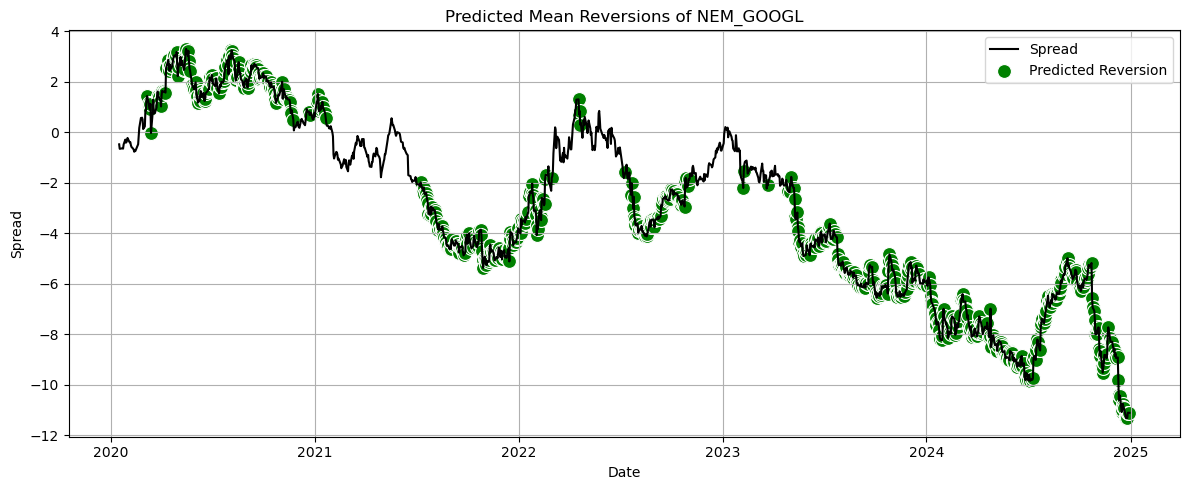

Confusion Matrix:
[[372 427]
 [ 32 416]]
F1 Score: 0.6445

Training model for pair: NEM_TSLA
Epoch 1/50 - Loss: 0.8822
Epoch 2/50 - Loss: 0.7649
Epoch 3/50 - Loss: 0.6001
Epoch 4/50 - Loss: 0.5133
Epoch 5/50 - Loss: 0.4344
Epoch 6/50 - Loss: 0.4207
Epoch 7/50 - Loss: 0.4102
Epoch 8/50 - Loss: 0.3955
Epoch 9/50 - Loss: 0.3779
Epoch 10/50 - Loss: 0.3647
Epoch 11/50 - Loss: 0.3514
Epoch 12/50 - Loss: 0.3401
Epoch 13/50 - Loss: 0.3305
Epoch 14/50 - Loss: 0.3219
Epoch 15/50 - Loss: 0.3139
Epoch 16/50 - Loss: 0.3062
Epoch 17/50 - Loss: 0.2989
Epoch 18/50 - Loss: 0.2918
Epoch 19/50 - Loss: 0.2849
Epoch 20/50 - Loss: 0.2783
Epoch 21/50 - Loss: 0.2720
Epoch 22/50 - Loss: 0.2657
Epoch 23/50 - Loss: 0.2600
Epoch 24/50 - Loss: 0.2541
Epoch 25/50 - Loss: 0.2493
Epoch 26/50 - Loss: 0.2439
Epoch 27/50 - Loss: 0.2404
Epoch 28/50 - Loss: 0.2350
Epoch 29/50 - Loss: 0.2326
Epoch 30/50 - Loss: 0.2270
Epoch 31/50 - Loss: 0.2243
Epoch 32/50 - Loss: 0.2185
Epoch 33/50 - Loss: 0.2150
Epoch 34/50 - Loss: 0.209

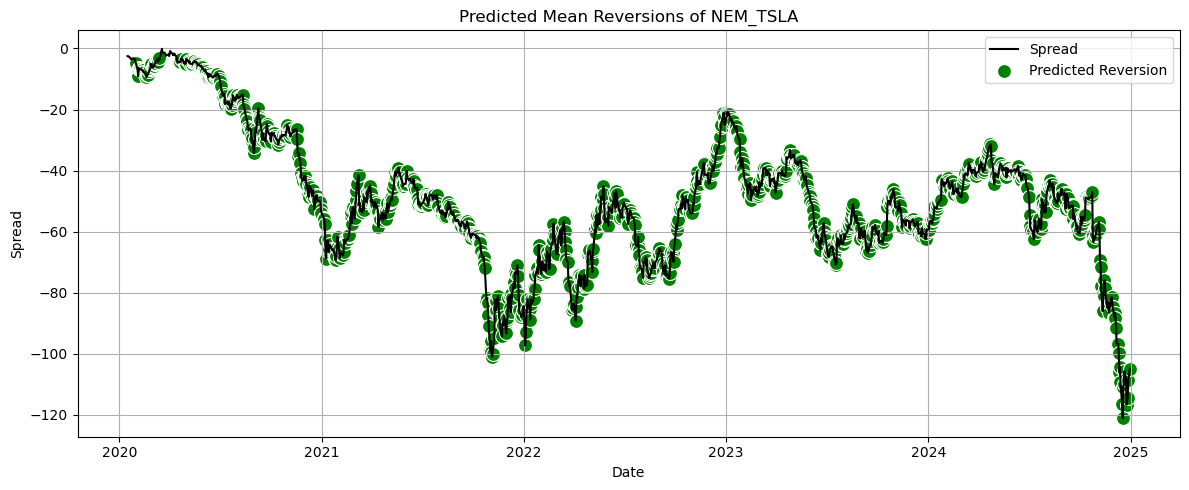

Confusion Matrix:
[[  0 904]
 [ 40 303]]
F1 Score: 0.3910

Training model for pair: NEM_GOOG
Epoch 1/50 - Loss: 0.9346
Epoch 2/50 - Loss: 0.8225
Epoch 3/50 - Loss: 0.7178
Epoch 4/50 - Loss: 0.5903
Epoch 5/50 - Loss: 0.5922
Epoch 6/50 - Loss: 0.4819
Epoch 7/50 - Loss: 0.4617
Epoch 8/50 - Loss: 0.4866
Epoch 9/50 - Loss: 0.4506
Epoch 10/50 - Loss: 0.4340
Epoch 11/50 - Loss: 0.4360
Epoch 12/50 - Loss: 0.4325
Epoch 13/50 - Loss: 0.4239
Epoch 14/50 - Loss: 0.4167
Epoch 15/50 - Loss: 0.4113
Epoch 16/50 - Loss: 0.4056
Epoch 17/50 - Loss: 0.3992
Epoch 18/50 - Loss: 0.3923
Epoch 19/50 - Loss: 0.3855
Epoch 20/50 - Loss: 0.3785
Epoch 21/50 - Loss: 0.3713
Epoch 22/50 - Loss: 0.3641
Epoch 23/50 - Loss: 0.3573
Epoch 24/50 - Loss: 0.3507
Epoch 25/50 - Loss: 0.3444
Epoch 26/50 - Loss: 0.3383
Epoch 27/50 - Loss: 0.3324
Epoch 28/50 - Loss: 0.3267
Epoch 29/50 - Loss: 0.3210
Epoch 30/50 - Loss: 0.3155
Epoch 31/50 - Loss: 0.3102
Epoch 32/50 - Loss: 0.3049
Epoch 33/50 - Loss: 0.2997
Epoch 34/50 - Loss: 0.294

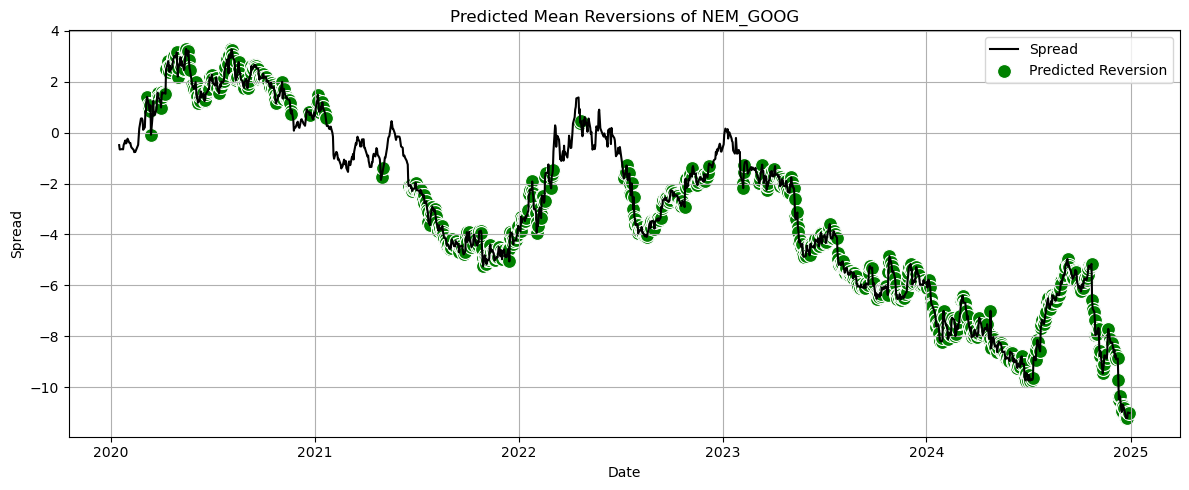

Confusion Matrix:
[[290 508]
 [ 37 412]]
F1 Score: 0.6019

Training model for pair: RCL_GOOGL
Epoch 1/50 - Loss: 0.8702
Epoch 2/50 - Loss: 0.8124
Epoch 3/50 - Loss: 0.6264
Epoch 4/50 - Loss: 0.5005
Epoch 5/50 - Loss: 0.4819
Epoch 6/50 - Loss: 0.4712
Epoch 7/50 - Loss: 0.4437
Epoch 8/50 - Loss: 0.4218
Epoch 9/50 - Loss: 0.4130
Epoch 10/50 - Loss: 0.4075
Epoch 11/50 - Loss: 0.3973
Epoch 12/50 - Loss: 0.3837
Epoch 13/50 - Loss: 0.3754
Epoch 14/50 - Loss: 0.3714
Epoch 15/50 - Loss: 0.3653
Epoch 16/50 - Loss: 0.3894
Epoch 17/50 - Loss: 0.3566
Epoch 18/50 - Loss: 0.3478
Epoch 19/50 - Loss: 0.3371
Epoch 20/50 - Loss: 0.3315
Epoch 21/50 - Loss: 0.3340
Epoch 22/50 - Loss: 0.3922
Epoch 23/50 - Loss: 0.3468
Epoch 24/50 - Loss: 0.3246
Epoch 25/50 - Loss: 0.3211
Epoch 26/50 - Loss: 0.3064
Epoch 27/50 - Loss: 0.2901
Epoch 28/50 - Loss: 0.2892
Epoch 29/50 - Loss: 0.2932
Epoch 30/50 - Loss: 0.2993
Epoch 31/50 - Loss: 0.2791
Epoch 32/50 - Loss: 0.2802
Epoch 33/50 - Loss: 0.2662
Epoch 34/50 - Loss: 0.27

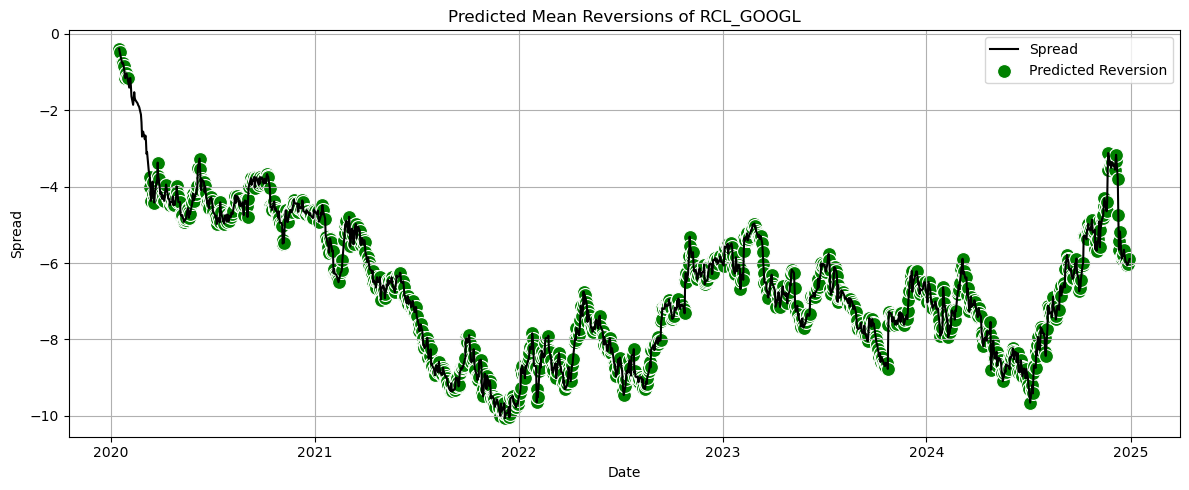

Confusion Matrix:
[[  0 802]
 [ 26 419]]
F1 Score: 0.5030

Training model for pair: RCL_TSLA
Epoch 1/50 - Loss: 1.0265
Epoch 2/50 - Loss: 0.9088
Epoch 3/50 - Loss: 0.8012
Epoch 4/50 - Loss: 0.6619
Epoch 5/50 - Loss: 0.5978
Epoch 6/50 - Loss: 0.5561
Epoch 7/50 - Loss: 0.5214
Epoch 8/50 - Loss: 0.4966
Epoch 9/50 - Loss: 0.4761
Epoch 10/50 - Loss: 0.4595
Epoch 11/50 - Loss: 0.4467
Epoch 12/50 - Loss: 0.4360
Epoch 13/50 - Loss: 0.4266
Epoch 14/50 - Loss: 0.4182
Epoch 15/50 - Loss: 0.4102
Epoch 16/50 - Loss: 0.4026
Epoch 17/50 - Loss: 0.3948
Epoch 18/50 - Loss: 0.3868
Epoch 19/50 - Loss: 0.3787
Epoch 20/50 - Loss: 0.3706
Epoch 21/50 - Loss: 0.3620
Epoch 22/50 - Loss: 0.3540
Epoch 23/50 - Loss: 0.3456
Epoch 24/50 - Loss: 0.3380
Epoch 25/50 - Loss: 0.3307
Epoch 26/50 - Loss: 0.3235
Epoch 27/50 - Loss: 0.3167
Epoch 28/50 - Loss: 0.3097
Epoch 29/50 - Loss: 0.3030
Epoch 30/50 - Loss: 0.2963
Epoch 31/50 - Loss: 0.2896
Epoch 32/50 - Loss: 0.2828
Epoch 33/50 - Loss: 0.2760
Epoch 34/50 - Loss: 0.269

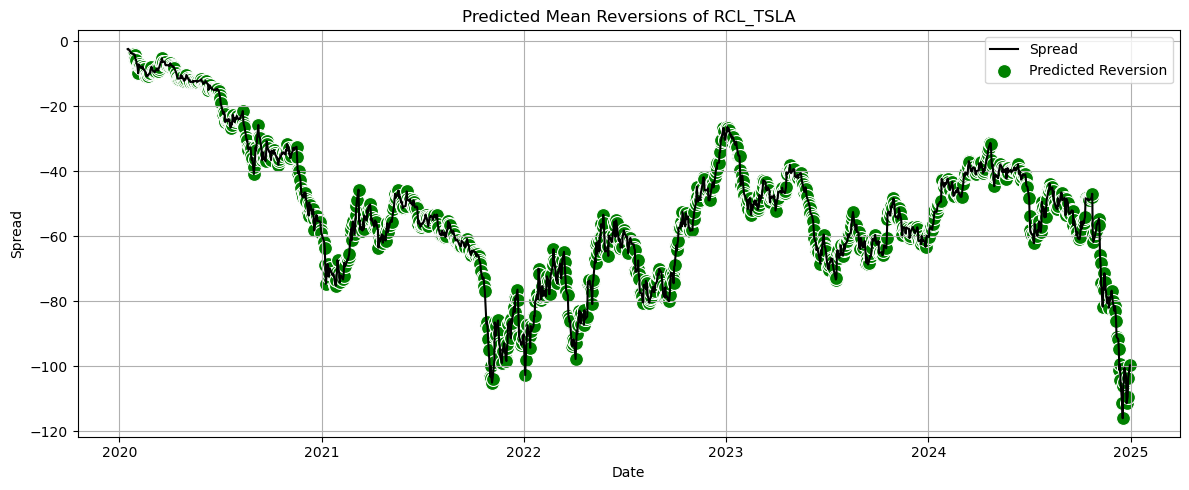

Confusion Matrix:
[[  0 901]
 [  7 339]]
F1 Score: 0.4275

Training model for pair: RCL_GOOG
Epoch 1/50 - Loss: 0.8514
Epoch 2/50 - Loss: 0.7834
Epoch 3/50 - Loss: 0.6091
Epoch 4/50 - Loss: 0.5124
Epoch 5/50 - Loss: 0.5503
Epoch 6/50 - Loss: 0.4643
Epoch 7/50 - Loss: 0.4361
Epoch 8/50 - Loss: 0.4334
Epoch 9/50 - Loss: 0.4291
Epoch 10/50 - Loss: 0.4169
Epoch 11/50 - Loss: 0.4048
Epoch 12/50 - Loss: 0.3968
Epoch 13/50 - Loss: 0.3900
Epoch 14/50 - Loss: 0.3828
Epoch 15/50 - Loss: 0.3754
Epoch 16/50 - Loss: 0.3682
Epoch 17/50 - Loss: 0.3608
Epoch 18/50 - Loss: 0.3530
Epoch 19/50 - Loss: 0.3457
Epoch 20/50 - Loss: 0.3397
Epoch 21/50 - Loss: 0.3333
Epoch 22/50 - Loss: 0.3294
Epoch 23/50 - Loss: 0.3216
Epoch 24/50 - Loss: 0.3447
Epoch 25/50 - Loss: 0.3190
Epoch 26/50 - Loss: 0.3185
Epoch 27/50 - Loss: 0.3175
Epoch 28/50 - Loss: 0.3101
Epoch 29/50 - Loss: 0.3018
Epoch 30/50 - Loss: 0.3001
Epoch 31/50 - Loss: 0.2997
Epoch 32/50 - Loss: 0.2931
Epoch 33/50 - Loss: 0.2839
Epoch 34/50 - Loss: 0.278

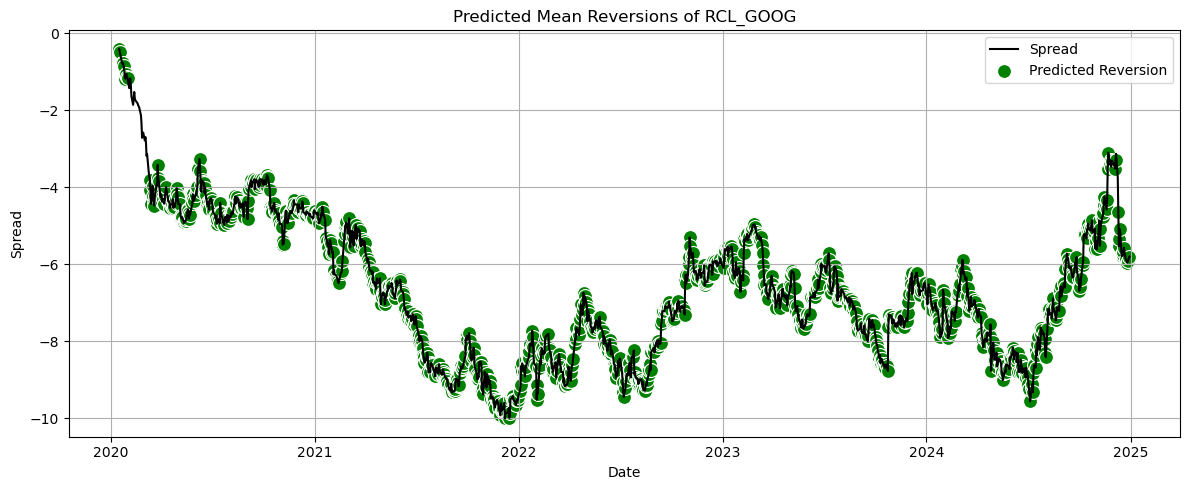

Confusion Matrix:
[[  0 796]
 [ 29 422]]
F1 Score: 0.5057

Training model for pair: MSI_GOOGL
Epoch 1/50 - Loss: 0.9157
Epoch 2/50 - Loss: 0.8291
Epoch 3/50 - Loss: 0.6427
Epoch 4/50 - Loss: 0.3801
Epoch 5/50 - Loss: 0.3089
Epoch 6/50 - Loss: 0.2789
Epoch 7/50 - Loss: 0.2738
Epoch 8/50 - Loss: 0.2673
Epoch 9/50 - Loss: 0.2619
Epoch 10/50 - Loss: 0.2577
Epoch 11/50 - Loss: 0.2527
Epoch 12/50 - Loss: 0.2484
Epoch 13/50 - Loss: 0.2431
Epoch 14/50 - Loss: 0.2395
Epoch 15/50 - Loss: 0.2362
Epoch 16/50 - Loss: 0.2418
Epoch 17/50 - Loss: 0.2315
Epoch 18/50 - Loss: 0.2260
Epoch 19/50 - Loss: 0.2250
Epoch 20/50 - Loss: 0.2293
Epoch 21/50 - Loss: 0.2344
Epoch 22/50 - Loss: 0.2359
Epoch 23/50 - Loss: 0.2437
Epoch 24/50 - Loss: 0.2267
Epoch 25/50 - Loss: 0.2137
Epoch 26/50 - Loss: 0.2014
Epoch 27/50 - Loss: 0.1975
Epoch 28/50 - Loss: 0.2889
Epoch 29/50 - Loss: 0.2123
Epoch 30/50 - Loss: 0.1983
Epoch 31/50 - Loss: 0.1891
Epoch 32/50 - Loss: 0.1822
Epoch 33/50 - Loss: 0.1786
Epoch 34/50 - Loss: 0.17

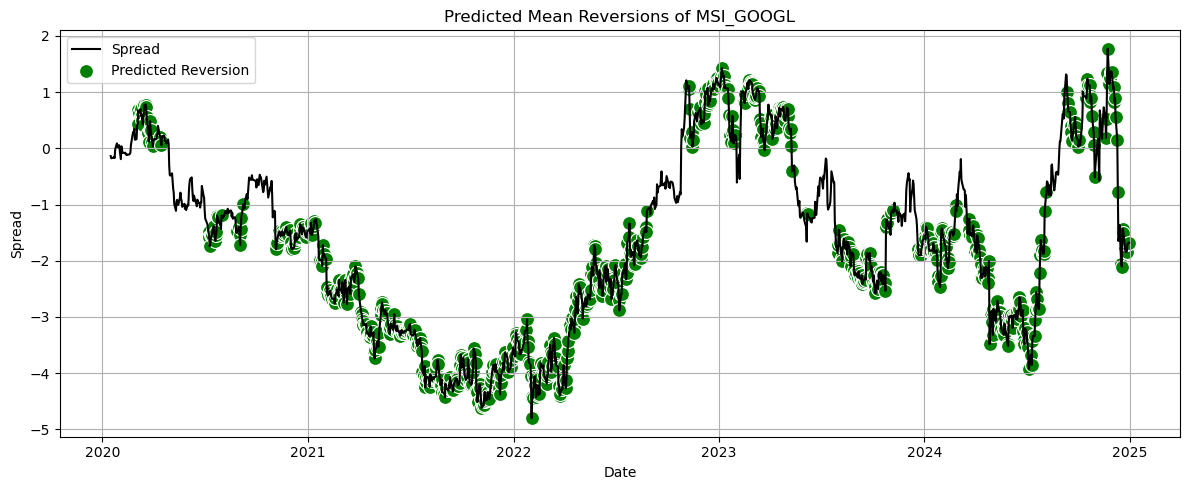

Confusion Matrix:
[[301 433]
 [ 85 428]]
F1 Score: 0.6230

Training model for pair: MSI_TSLA
Epoch 1/50 - Loss: 1.2261
Epoch 2/50 - Loss: 0.9794
Epoch 3/50 - Loss: 0.8911
Epoch 4/50 - Loss: 0.6624
Epoch 5/50 - Loss: 0.5554
Epoch 6/50 - Loss: 0.4444
Epoch 7/50 - Loss: 0.3798
Epoch 8/50 - Loss: 0.3631
Epoch 9/50 - Loss: 0.3504
Epoch 10/50 - Loss: 0.3447
Epoch 11/50 - Loss: 0.3383
Epoch 12/50 - Loss: 0.3341
Epoch 13/50 - Loss: 0.3301
Epoch 14/50 - Loss: 0.3269
Epoch 15/50 - Loss: 0.3239
Epoch 16/50 - Loss: 0.3212
Epoch 17/50 - Loss: 0.3187
Epoch 18/50 - Loss: 0.3163
Epoch 19/50 - Loss: 0.3141
Epoch 20/50 - Loss: 0.3120
Epoch 21/50 - Loss: 0.3100
Epoch 22/50 - Loss: 0.3081
Epoch 23/50 - Loss: 0.3062
Epoch 24/50 - Loss: 0.3043
Epoch 25/50 - Loss: 0.3024
Epoch 26/50 - Loss: 0.3005
Epoch 27/50 - Loss: 0.2985
Epoch 28/50 - Loss: 0.2964
Epoch 29/50 - Loss: 0.2943
Epoch 30/50 - Loss: 0.2922
Epoch 31/50 - Loss: 0.2899
Epoch 32/50 - Loss: 0.2875
Epoch 33/50 - Loss: 0.2850
Epoch 34/50 - Loss: 0.282

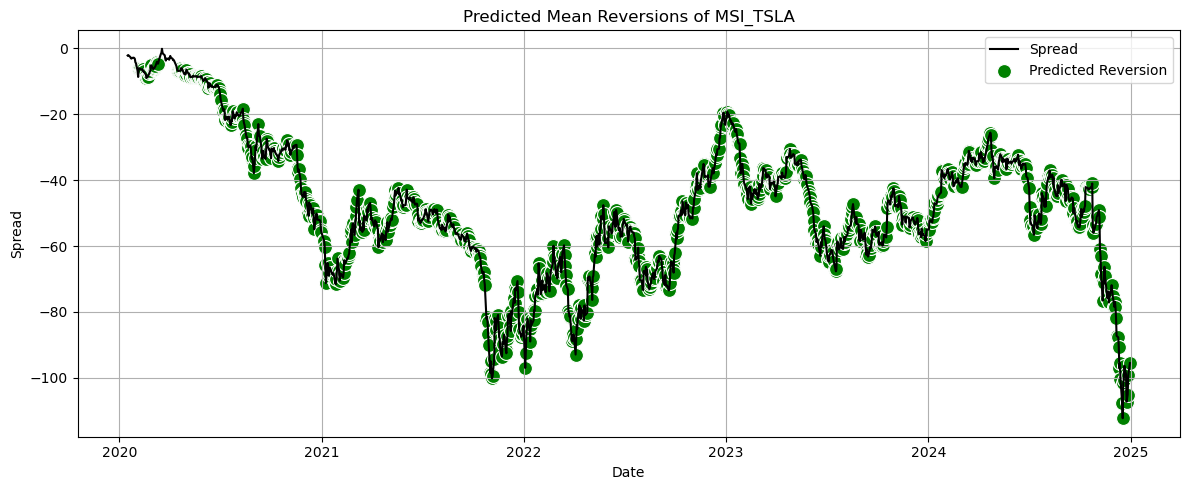

Confusion Matrix:
[[  0 894]
 [ 37 316]]
F1 Score: 0.4044

Training model for pair: MSI_GOOG
Epoch 1/50 - Loss: 0.9032
Epoch 2/50 - Loss: 0.7844
Epoch 3/50 - Loss: 0.4858
Epoch 4/50 - Loss: 0.3474
Epoch 5/50 - Loss: 0.2751
Epoch 6/50 - Loss: 0.2977
Epoch 7/50 - Loss: 0.2722
Epoch 8/50 - Loss: 0.2817
Epoch 9/50 - Loss: 0.2725
Epoch 10/50 - Loss: 0.2766
Epoch 11/50 - Loss: 0.2647
Epoch 12/50 - Loss: 0.2655
Epoch 13/50 - Loss: 0.2492
Epoch 14/50 - Loss: 0.2507
Epoch 15/50 - Loss: 0.2366
Epoch 16/50 - Loss: 0.2380
Epoch 17/50 - Loss: 0.2265
Epoch 18/50 - Loss: 0.2323
Epoch 19/50 - Loss: 0.2355
Epoch 20/50 - Loss: 0.2271
Epoch 21/50 - Loss: 0.2208
Epoch 22/50 - Loss: 0.2236
Epoch 23/50 - Loss: 0.2207
Epoch 24/50 - Loss: 0.2184
Epoch 25/50 - Loss: 0.2169
Epoch 26/50 - Loss: 0.2154
Epoch 27/50 - Loss: 0.2173
Epoch 28/50 - Loss: 0.2171
Epoch 29/50 - Loss: 0.2199
Epoch 30/50 - Loss: 0.2218
Epoch 31/50 - Loss: 0.2028
Epoch 32/50 - Loss: 0.1931
Epoch 33/50 - Loss: 0.1981
Epoch 34/50 - Loss: 0.241

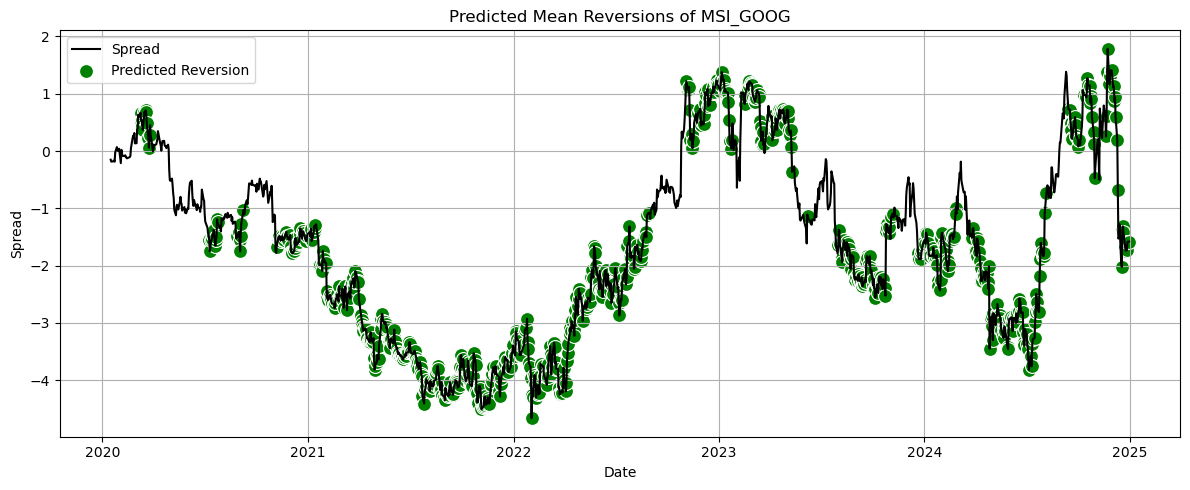

Confusion Matrix:
[[307 425]
 [101 414]]
F1 Score: 0.6115
{'NEM_GOOGL': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_layers=2, batch_first=True)
  (linear): Linear(in_features=70, out_features=1, bias=True)
), 'y_true': array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], shape=(1247, 1), dtype=float32), 'y_pred': array([0.00329324, 0.00258505, 0.00281735, ..., 0.9999124 , 0.9999124 ,
       0.9999124 ], shape=(1247,), dtype=float32)}, 'NEM_TSLA': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_layers=2, batch_first=True)
  (linear): Linear(in_features=70, out_features=1, bias=True)
), 'y_true': array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], shape=(1247, 1), dtype=float32), 'y_pred': array([1.8657439e-03, 1.1257821e-03, 9.5397700e-04, ..., 9.9995971e-01,
       9.9995971e-01, 9.9995959e-01], shape=(1247,), dtype=float32)}, 'NEM_GOOG': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, 

In [14]:
results = {}

# param_grid = {
#     'hidden_size': [30, 70],
#     'learning_rate': [0.001, 0.0005, 0.0001],
#     'window_size': [3, 5, 7],
#     'epochs': [50],
#     'num_layers': [1, 2],
#     'batch_size': [32, 64, 128],
#     'dropout': [0.0, 0.2]
# }

# best_params_all = {}
# best_f1_all = {}

# for pair_name in training_spreads_df.columns:
#     print(f"\nStarting grid search for {pair_name}")
#     model, params, f1 = grid_search_for_pair(pair_name, param_grid, device='cpu')
#     results[pair_name] = {'model': model}
#     best_params_all[pair_name] = params
#     best_f1_all[pair_name] = f1

for pair_name in training_spreads_df.columns:
    model, y_true, y_pred = run_pair(
        pair_name,
        X_train_dict,
        y_train_dict,
        X_test_dict,
        y_test_dict,
        epochs = 50,
        device = 'cpu'
    )
    results[pair_name] = {'model': model, 'y_true': y_true, 'y_pred': y_pred}

print(results)

In [15]:
def build_prices(pair_list, testing_data, X_test_dict):
    test_prices_dict = {}

    for pair in pair_list:
        etf1, etf2 = pair.split('_')

        data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High', 'Low']]
        new_data = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4

        price_df = new_data[[etf1, etf2]].copy()
        price_df.columns = ['price_long', 'price_short']

        test_index = X_test_dict[pair].index
        aligned_prices = price_df.loc[test_index]

        test_prices_dict[pair] = aligned_prices

    return test_prices_dict

In [16]:
def compute_max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    drawdowns = equity_curve / running_max - 1.0
    max_drawdown = drawdowns.min()
    
    return max_drawdown, drawdowns

In [17]:
def plot_combined_equity_and_drawdown(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax[0].plot(equity, label='Combined Equity')
    ax[0].set_title("Combined Equity Curve")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(drawdown, color='red', label='Drawdown')
    ax[1].set_title("Drawdown Over Time")
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()


In [18]:
def simulate_portfolio(
    X_df, probs, y_pred_label, prices_df,
    initial_cash_per_pair = 100.0,
    holding_period = 10,
    entry_threshold = 1.0,
):
    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    df['prob'] = probs
    df['label'] = y_pred_label
    df = df.join(prices_df)

    cash = initial_cash_per_pair
    equity = pd.Series(index = df.index, dtype = float)
    equity.iloc[0] = cash
    trades = []

    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        prob = row['prob']
        zscore = row['z-score']
        price_long_in = row['price_long']
        price_short_in = row['price_short']

        if (prob > 0.5 and abs(zscore) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price_long_out = df.iloc[exit_idx]['price_long']
            price_short_out = df.iloc[exit_idx]['price_short']

            notional = cash
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if zscore > 0:
                shares_short_long = short_dollars / price_long_in
                shares_long_short = long_dollars / price_short_in

                pnl = (shares_long_short * (price_short_out - price_short_in)) + \
                      (shares_short_long * (price_long_in - price_long_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                shares_long_long = long_dollars / price_long_in
                shares_short_short = short_dollars / price_short_in

                pnl = (shares_long_long * (price_long_out - price_long_in)) + \
                      (shares_short_short * (price_short_in - price_short_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[exit_date] = cash

            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "prob": prob,
                "direction": direction,
                "pnl": pnl,
                "notional": notional
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace = True)
    return equity, trades

In [19]:
def run_simulation(results, X_test_dict, testing_data):
    pair_list = list(X_test_dict.keys())
    test_prices_dict = build_prices(pair_list, testing_data, X_test_dict)

    total_cash = 0
    combined_equity = pd.Series(dtype=float)
    pair_trade_counts = {}
    pair_pnls = {}
    pair_sharpes = {}
    pair_drawdowns = {}
    pair_equities = {}

    plt.figure(figsize=(12, 6))

    for pair_name in pair_list:
        model_info = results[pair_name]
        model = model_info['model']
        y_true = model_info['y_true']
        y_pred = model_info['y_pred']

        probs = torch.sigmoid(torch.tensor(y_pred)).squeeze().numpy()
        y_pred_label = (probs > 0.5).astype(int)

        prices_df = test_prices_dict[pair_name]
        X_test_df = X_test_dict[pair_name]

        equity, trades = simulate_portfolio(X_test_df, probs, y_pred_label, prices_df)

        pair_equities[pair_name] = equity
        max_dd, _ = compute_max_drawdown(equity)
        pair_drawdowns[pair_name] = max_dd

        pair_returns = equity.pct_change().dropna()

        if pair_returns.std() != 0:
            sharpe = (pair_returns.mean() / pair_returns.std()) * np.sqrt(252)
        else:
            sharpe = np.nan

        pair_sharpes[pair_name] = sharpe

        total_cash += equity.iloc[-1]
        pair_trade_counts[pair_name] = len(trades)
        pair_pnls[pair_name] = [t['pnl'] for t in trades]

        if combined_equity.empty:
            equity.name = pair_name
            combined_equity = equity.to_frame()
        else:
            equity.name = pair_name
            combined_equity = pd.concat([combined_equity, equity], axis=1)

        sns.lineplot(x = equity.index, y = equity.values, label = pair_name)

    combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')
    combined_equity['Total'] = combined_equity.sum(axis=1)


    plt.title("LSTM Equity Curve by Pair", fontsize=15, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value ($)", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
    print("\nTrade Summary:")
    for pair, count in pair_trade_counts.items():
        total_pnl = sum(pair_pnls[pair])
        avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
        print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    yearly = combined_equity.resample('YE').last()
    print("\nYear-End Portfolio Values:")
    print(yearly)

    print("\nSharpe Ratios by Pair:")
    for pair, sharpe in pair_sharpes.items():
        print(f"{pair}: Sharpe Ratio = {sharpe:.2f}")

    combined_returns = combined_equity['Total'].pct_change().dropna()
    sharpe_ratio = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
    print(f"\nTotal Sharpe Ratio: {sharpe_ratio:.2f}")

    print("\nMax Drawdowns by Pair:")
    for pair, drawdown in pair_drawdowns.items():
        print(f"{pair}: Max Drawdown = {drawdown:.2%}")

    max_dd, drawdowns = compute_max_drawdown(combined_equity['Total'])
    print(f"\nTotal Max Drawdown: {max_dd:.2%}")

    plot_combined_equity_and_drawdown(combined_equity['Total'])

    for pair in combined_equity.columns:
        print(f"Pair: {pair}")
        print(combined_equity[pair].tail(10))  # show last 10 rows for this pair
        print("-" * 40)

    cumulative_equity = combined_equity['Total']
    cumulative_equity.to_csv("lstm_equity.csv", header=["Portfolio Value"])

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24324/3354488015.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High', 'Low']]
[*********************100%***********************]  6 of 6 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24324/3354488015.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High', 'Low']]
[*********************100%***********************]  6 of 6 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24324/3354488015.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High', 'Lo

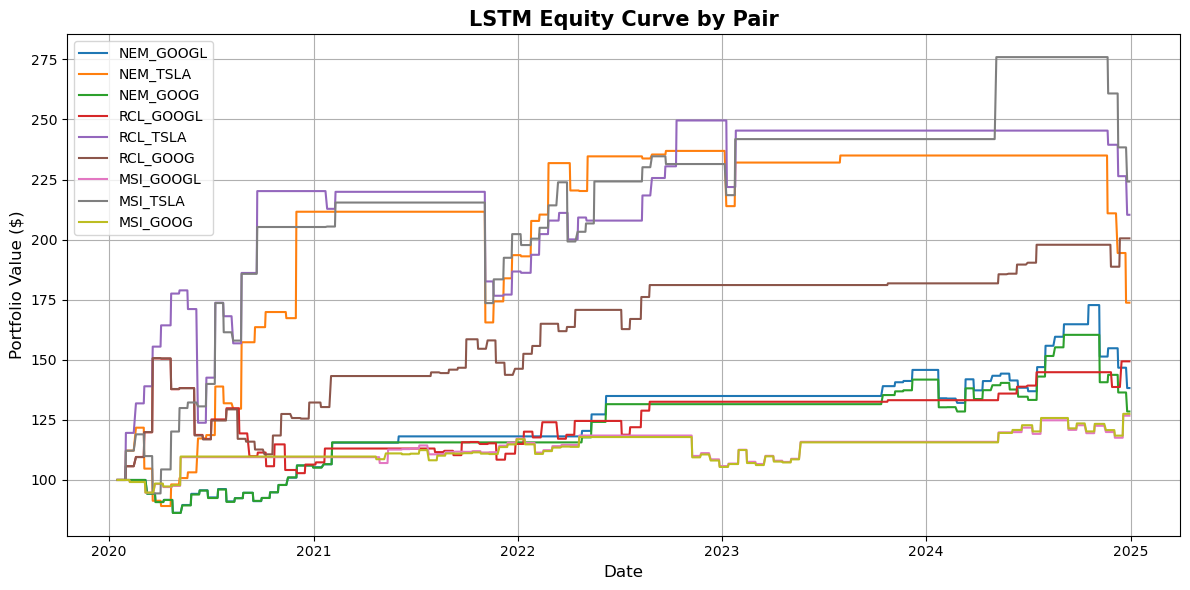


Final Portfolio Value: $1,479.14

Trade Summary:
  NEM_GOOGL: 49 trades | Total PnL: $38.25 | Avg PnL: $0.78
  NEM_TSLA: 38 trades | Total PnL: $73.76 | Avg PnL: $1.94
  NEM_GOOG: 47 trades | Total PnL: $28.49 | Avg PnL: $0.61
  RCL_GOOGL: 49 trades | Total PnL: $49.36 | Avg PnL: $1.01
  RCL_TSLA: 38 trades | Total PnL: $110.32 | Avg PnL: $2.90
  RCL_GOOG: 50 trades | Total PnL: $100.52 | Avg PnL: $2.01
  MSI_GOOGL: 54 trades | Total PnL: $26.75 | Avg PnL: $0.50
  MSI_TSLA: 39 trades | Total PnL: $124.17 | Avg PnL: $3.18
  MSI_GOOG: 54 trades | Total PnL: $27.51 | Avg PnL: $0.51

Year-End Portfolio Values:
             NEM_GOOGL    NEM_TSLA    NEM_GOOG   RCL_GOOGL    RCL_TSLA  \
Date                                                                     
2020-12-31  105.312254  211.598329  105.127595  106.407057  220.184509   
2021-12-31  118.136775  193.537545  115.638863  114.982256  186.728734   
2022-12-31  134.939459  236.904905  131.534095  132.544037  249.563890   
2023-12-31  145

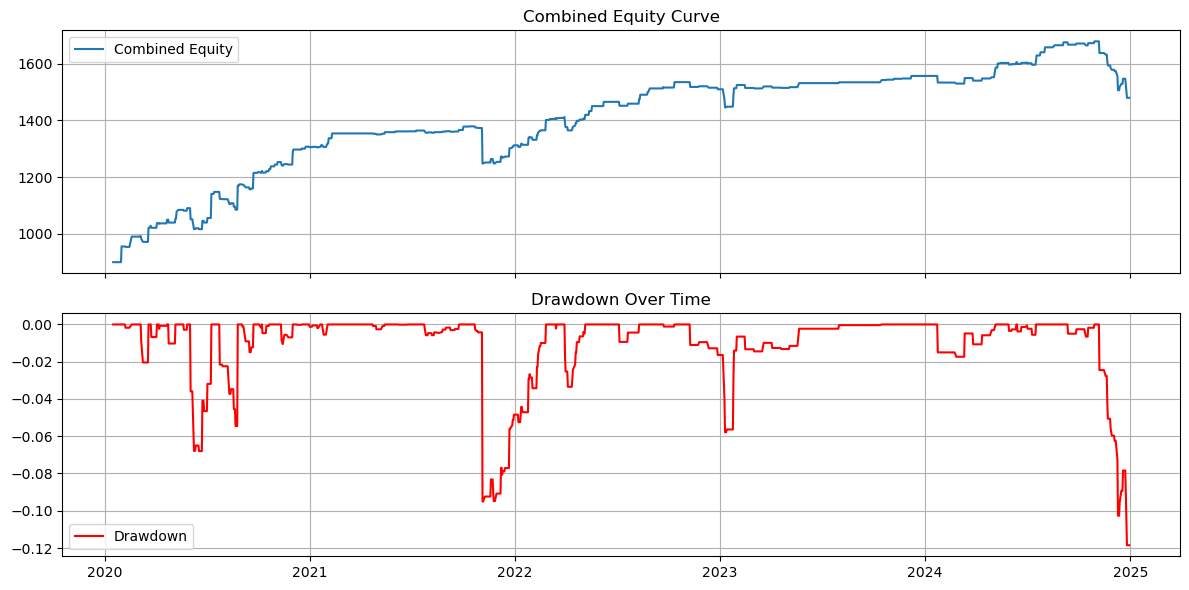

Pair: NEM_GOOGL
Date
2024-12-16    146.708810
2024-12-17    146.708810
2024-12-18    146.708810
2024-12-19    146.708810
2024-12-20    146.708810
2024-12-23    146.708810
2024-12-24    146.708810
2024-12-26    138.246955
2024-12-27    138.246955
2024-12-30    138.246955
Name: NEM_GOOGL, dtype: float64
----------------------------------------
Pair: NEM_TSLA
Date
2024-12-16    194.428531
2024-12-17    194.428531
2024-12-18    194.428531
2024-12-19    194.428531
2024-12-20    194.428531
2024-12-23    194.428531
2024-12-24    173.763853
2024-12-26    173.763853
2024-12-27    173.763853
2024-12-30    173.763853
Name: NEM_TSLA, dtype: float64
----------------------------------------
Pair: NEM_GOOG
Date
2024-12-16    136.402613
2024-12-17    136.402613
2024-12-18    136.402613
2024-12-19    136.402613
2024-12-20    136.402613
2024-12-23    136.402613
2024-12-24    136.402613
2024-12-26    128.494863
2024-12-27    128.494863
2024-12-30    128.494863
Name: NEM_GOOG, dtype: float64
-------------

In [20]:
run_simulation(results, X_test_dict, testing_data)